# Sentiment Analysis

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows',5000)

In [2]:
# importing dataset
df = pd.read_csv("data_for_sentiment_analysis",delimiter='\t')

In [3]:
# Top 5 row of dataset
df.head()

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [4]:
df.shape

(6918, 2)

In [5]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [6]:
df.sentiment.value_counts()

1    3943
0    2975
Name: sentiment, dtype: int64

1 stands for positive sentiment,
0 stands for negative sentiment

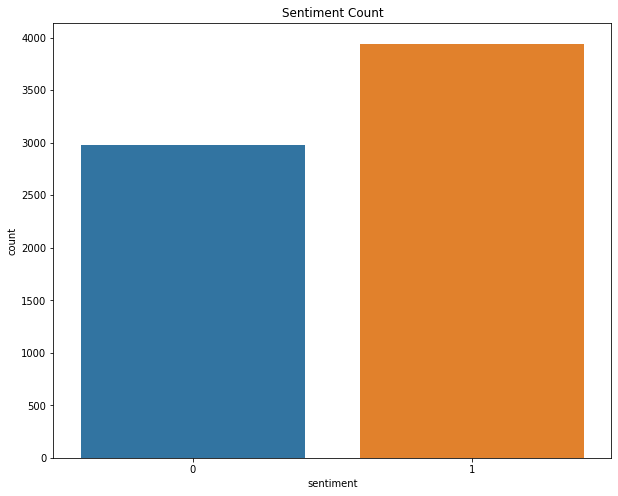

In [7]:
plt.figure(figsize = (10,8))
sns.countplot(x = 'sentiment', data =df)
plt.title('Sentiment Count')
plt.show()

# Preprocessing of Data

In [8]:
for i,j in enumerate(df.text.head()):
    print("sentiment:",df['sentiment'][i],"Text:",j)
    print("********"*10)

sentiment: 1 Text: The Da Vinci Code book is just awesome.
********************************************************************************
sentiment: 1 Text: this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this.
********************************************************************************
sentiment: 1 Text: i liked the Da Vinci Code a lot.
********************************************************************************
sentiment: 1 Text: i liked the Da Vinci Code a lot.
********************************************************************************
sentiment: 1 Text: I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.
********************************************************************************


We can see that it is about The Da Vinci Code (Book), Harry Potter (Movie), Brokeback Mountain (Movie) and Mission Impossible (Movie)

## Converting Data to Lowercase

In [9]:
df['text'] = df['text'].str.lower()

In [10]:
df['text'].head()

0              the da vinci code book is just awesome.
1    this was the first clive cussler i've ever rea...
2                     i liked the da vinci code a lot.
3                     i liked the da vinci code a lot.
4    i liked the da vinci code but it ultimatly did...
Name: text, dtype: object

## Removing Special character, Digits and non-ASCII character

In [11]:
# text cleaning
def text_cleaning(text):
    
    text = re.sub(r"[^A-z\s]","",text)
    text = re.sub(r"\d+","",text)
    str_enco = text.encode('ascii','ignore')
    text = str_enco.decode()
    
    return text

In [12]:
df['text'] = df['text'].apply(text_cleaning)

## Removing Punctuation

In [13]:
# there is punctuation in text, we need to remove it
df.text[46]

'looks amazingly fun and possibly a bit cold [ dont tell anyone ] but da vinci code is an awesome book'

In [14]:
punctuation = string.punctuation

In [15]:
def remove_punctuation(text):
    
    return text.translate(str.maketrans('','',punctuation))

In [16]:
df['text'] = df['text'].apply(remove_punctuation)

In [17]:
# punctuation is removed.
df.text[46]

'looks amazingly fun and possibly a bit cold  dont tell anyone  but da vinci code is an awesome book'

## Removing Stopwords

In [18]:
# importing english stopwords
english_stopwords = stopwords.words('english')
english_stopwords.remove('no')
english_stopwords.remove('not')
english_stopwords.remove('nor')

In [19]:
def remove_stopwords(text):
    lst = []
    for word in text.split():
        if word not in english_stopwords:
            lst.append(word)
            
    return " ".join(lst)

In [20]:
df['text'] = df['text'].apply(remove_stopwords)

## Lemmatization of Data

In [21]:
# importing WordNetLemmatizer
lemmitizer = WordNetLemmatizer()

In [22]:
def lemmitization(text):
    lst = []
    for word in text.split():
        lst.append(lemmitizer.lemmatize(word))
        
    return " ".join(lst)

In [23]:
df['text'] = df['text'].apply(lemmitization)

## Removing Single Character

In [24]:
def remove_singlechar(text):
    lst = []
    for word in text.split():
        if len(word) > 1:
            lst.append(word)
            
    return " ".join(lst)

In [25]:
df['text'] = df['text'].apply(remove_singlechar)

In [26]:
df['text'] = df['text'].str.strip()

## Checking Word Frequency

In [27]:
# checking which word appeared most of times in dataset
def gen_freq(text):
    lst = []
    for word in text.split():
        lst.extend(word)
        
    word_freq = pd.Series(lst).value_counts()
    return word_freq

In [28]:
word_freq = gen_freq(df.text.str)

In [29]:
word_freq

potter        2093
harry         2088
vinci         2001
da            1998
brokeback     1997
              ... 
yip              1
leder            1
gyllenhaal       1
middle           1
codeother        1
Length: 1959, dtype: int64

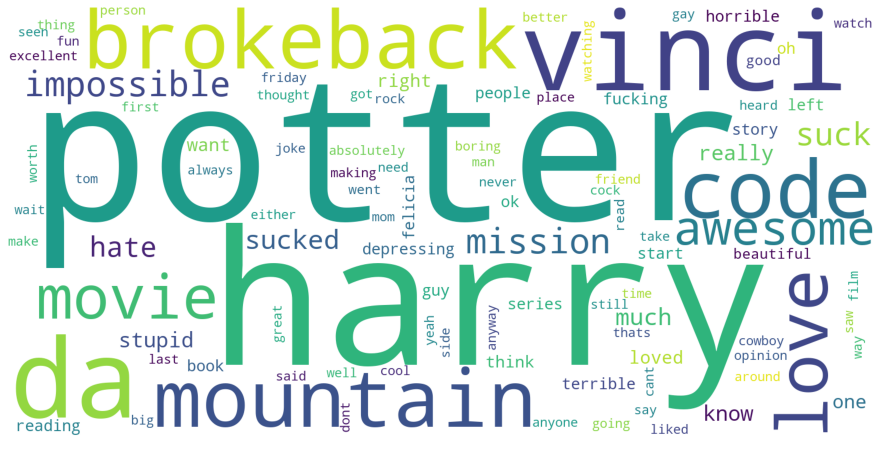

In [30]:
# wordcloud for word frequency
word_cloud = WordCloud(max_words = 100, width = 1600, height = 800, collocations = False, 
                       background_color = 'white').generate(' '.join(df['text']))
plt.figure(figsize = (18,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

From word cloud also we can see that it is about Harry Potter (Movie), The Da Vinci Code (Book) , Brokeback Mountain (Movie) and Mission Impossible (Movie)

In [31]:
# checking review distribution for each content
def total_review_func(title):
    total_review = []
    negative_review = []
    positive_review = []
    
    for word in title:
        total_review.append(df[df.text.str.contains(word)].shape[0])
        negative_review.append(df[(df.text.str.contains(word)) & (df.sentiment == 0)].shape[0])
        positive_review.append(df[(df.text.str.contains(word)) & (df.sentiment == 1)].shape[0])
        
    return total_review, negative_review, positive_review

In [32]:
title = ['harry','mountain',' vinci','impossible']

In [33]:
total_review, negative_review, positive_review = total_review_func(title)

In [34]:
print(f'Total Reviews[Harry Potter,Brokeback Mountain,The Da Vinci Code,Mission:Impossible]:{total_review}')
print(f'Sum of Total Reviews:{sum(total_review)}')
print(f'Total Rows in Dataset:{df.shape[0]}')

Total Reviews[Harry Potter,Brokeback Mountain,The Da Vinci Code,Mission:Impossible]:[1916, 1930, 1982, 1090]
Sum of Total Reviews:6918
Total Rows in Dataset:6918


We can see that sum of total reviews is same as total rows, It means that We haven't missed any row.

In [35]:
name = ['Harry Potter','Brokeback Mountain','The Da Vinci Code','Mission:Impossible']

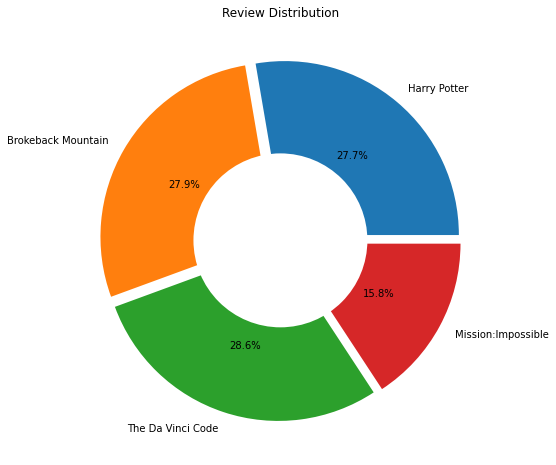

In [36]:
plt.figure(figsize=(10,8))
plt.pie(total_review,labels = name, autopct="%.1f%%", explode=[0.04 for i in range(len(name))])
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Review Distribution')
plt.show()

All content have same number of records except Mission Impossible which has 15.8% records only(1090 Records)

In [37]:
# Negative review for each content
print(f'Negative Reviews[Harry Potter,Brokeback Mountain,The Da Vinci Code,Mission:Impossible]:{negative_review}')

Negative Reviews[Harry Potter,Brokeback Mountain,The Da Vinci Code,Mission:Impossible]:[920, 971, 992, 92]


In [38]:
# Positive review for each content
print(f'Positive Reviews[Harry Potter,Brokeback Mountain,The Da Vinci Code,Mission:Impossible]:{positive_review}')

Positive Reviews[Harry Potter,Brokeback Mountain,The Da Vinci Code,Mission:Impossible]:[996, 959, 990, 998]


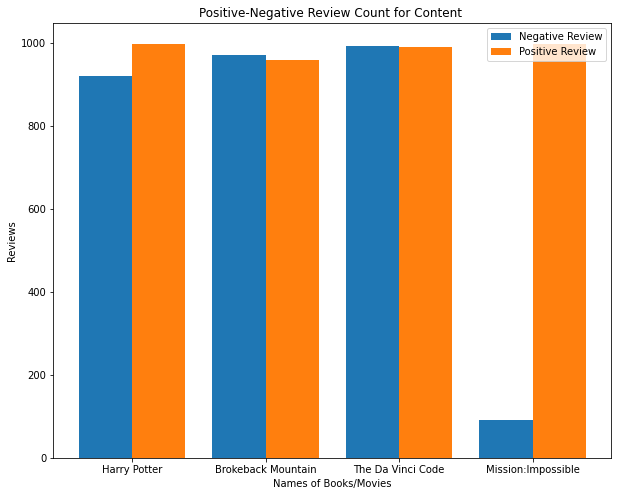

In [39]:
plt.figure(figsize=(10,8))
name_axis = np.arange(len(name))
plt.bar(name_axis - 0.2, negative_review, 0.4, label = 'Negative Review')
plt.bar(name_axis + 0.2, positive_review, 0.4, label = 'Positive Review')

plt.xticks(name_axis,name)
plt.xlabel('Names of Books/Movies')
plt.ylabel('Reviews')
plt.title('Positive-Negative Review Count for Content ')
plt.legend()
plt.show()

Mission Impossible has around 91% postitive review,Even if it has less number of records.

In [40]:
stopwords = ['harry','potter','brokeback','mountain','davinci','da','vinci','code','mission','impossible']

In [41]:
# removing content name for sentiment analysis
def remove_name(text):
    
    lst = []
    for word in text.split():
        if word not in stopwords:
            lst.append(word)
    
    return " ".join(lst)

In [42]:
df['text'] = df['text'].apply(remove_name)

In [43]:
df.head()

,sentiment,text
0,1,book awesome
1,1,first clive cussler ive ever read even book li...
2,1,liked lot
3,1,liked lot
4,1,liked ultimatly didnt seem hold


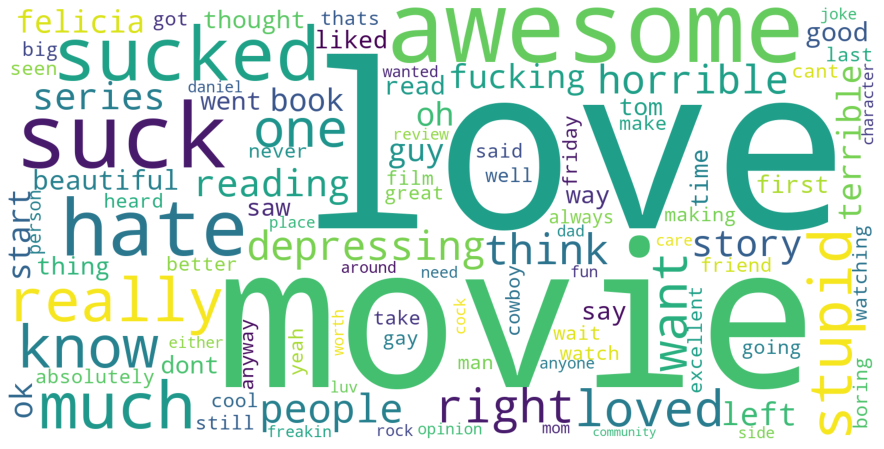

In [44]:
# wordcloud after removing content name
word_cloud = WordCloud(max_words = 100, width = 1600, height = 800, collocations = False, 
                       background_color = 'white').generate(' '.join(df['text']))
plt.figure(figsize = (18,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

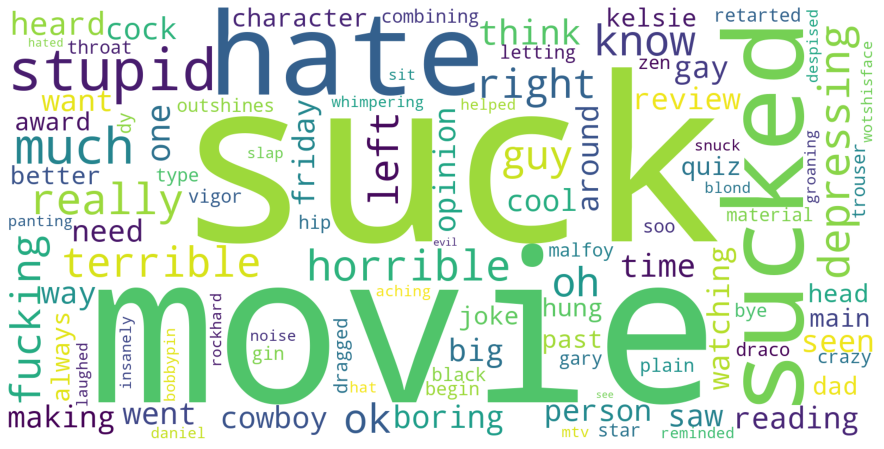

In [45]:
# wordcloud of negative sentiment
word_cloud = WordCloud(max_words = 100, width = 1600, height = 800, collocations = False, 
                       background_color = 'white').generate(' '.join(df.text[df['sentiment']==0]))
plt.figure(figsize = (18,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

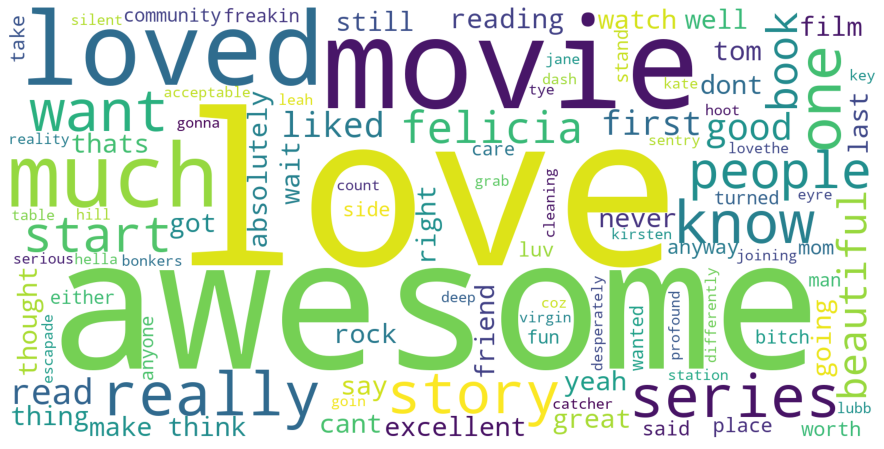

In [46]:
# wordcloud of positive sentiment
word_cloud = WordCloud(max_words = 100, width = 1600, height = 800, collocations = False, 
                       background_color = 'white').generate(' '.join(df.text[df['sentiment']==1]))
plt.figure(figsize = (18,8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Splitting Data into train and test

In [47]:
X = df.drop('sentiment',axis=1)
X.head()

,text
0,book awesome
1,first clive cussler ive ever read even book li...
2,liked lot
3,liked lot
4,liked ultimatly didnt seem hold


In [48]:
y = df['sentiment']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: sentiment, dtype: int64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 14)

In [50]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4842, 1) (2076, 1) (4842,) (2076,)


# Feature Extraction

In [51]:
X_train_tfv = X_train.copy()
X_test_tfv = X_test.copy()
y_train_tfv = y_train.copy()
y_test_tfv = y_test.copy()
# dictionary for comparing model accuracy
model_comparison = {}

In [52]:
tfidf = TfidfVectorizer(max_features = 10000)
X_train_tfv1 = tfidf.fit_transform(X_train_tfv.text)
X_test_tfv1 = tfidf.transform(X_test_tfv.text)
X_train_tfv_arr = X_train_tfv1.toarray()
X_test_tfv_arr = X_test_tfv1.toarray()

In [53]:
print("Number of feature Extracted:")
print(len(tfidf.get_feature_names()))
print(tfidf.get_feature_names()[:10])

Number of feature Extracted:
1491
['aaron', 'able', 'abortion', 'abrams', 'absolutely', 'absurd', 'academy', 'acceptable', 'accompaniment', 'account']


# Naive Bayes

In [54]:
mnb  = MultinomialNB()
mnb.fit(X_train_tfv_arr, y_train_tfv)
y_predict_mnb_train = mnb.predict(X_train_tfv_arr)
y_predict_mnb = mnb.predict(X_test_tfv_arr)
print(f"Train Accuracy:{accuracy_score(y_train_tfv, y_predict_mnb_train)*100:.2f}%")
print(f"Test Accuracy:{accuracy_score(y_test_tfv, y_predict_mnb)*100:.2f}%")
print(f"F1-Score:{f1_score(y_test_tfv, y_predict_mnb)*100:.2f}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_tfv, y_predict_mnb)}")
model_comparison['Naive Bayes'] = [round(accuracy_score(y_test_tfv, y_predict_mnb)*100,2), round(f1_score(y_test_tfv, y_predict_mnb)*100,2)]

Train Accuracy:99.40%
Test Accuracy:98.22%
F1-Score:98.44%
Confusion Matrix:
[[ 870   23]
 [  14 1169]]


# Decision Tree

In [55]:
DT = DecisionTreeClassifier(max_depth = 6, random_state=14)
DT.fit(X_train_tfv_arr, y_train_tfv)
y_predict_DT_train = DT.predict(X_train_tfv_arr)
y_predict_DT = DT.predict(X_test_tfv_arr)
print(f"Train Accuracy:{accuracy_score(y_train_tfv, y_predict_DT_train)*100:.2f}%")
print(f"Test Accuracy:{accuracy_score(y_test_tfv, y_predict_DT)*100:.2f}%")
print(f"F1-Score:{f1_score(y_test_tfv, y_predict_DT)*100:.2f}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_tfv, y_predict_DT)}")
model_comparison['Decision Tree'] = [round(accuracy_score(y_test_tfv, y_predict_DT)*100,2), round(f1_score(y_test_tfv, y_predict_DT)*100,2)]

Train Accuracy:95.00%
Test Accuracy:94.46%
F1-Score:94.91%
Confusion Matrix:
[[ 889    4]
 [ 111 1072]]


# Random Forest

In [56]:
rf = RandomForestClassifier(max_depth = 6, random_state=14)
rf.fit(X_train_tfv_arr, y_train_tfv)
y_predict_rf_train = rf.predict(X_train_tfv_arr)
y_predict_rf = rf.predict(X_test_tfv_arr)
print(f"Train Accuracy:{accuracy_score(y_train_tfv, y_predict_rf_train)*100:.2f}%")
print(f"Test Accuracy:{accuracy_score(y_test_tfv, y_predict_rf)*100:.2f}%")
print(f"F1-Score:{f1_score(y_test_tfv, y_predict_rf)*100:.2f}%")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_tfv, y_predict_rf)}")
model_comparison['Random Forest'] = [round(accuracy_score(y_test_tfv, y_predict_rf)*100,2), round(f1_score(y_test_tfv, y_predict_rf)*100,2)]

Train Accuracy:90.73%
Test Accuracy:90.99%
F1-Score:92.68%
Confusion Matrix:
[[ 706  187]
 [   0 1183]]


# Accuracy Comparison

In [57]:
model_com_df = pd.DataFrame(model_comparison).T
model_com_df.columns = ['Accuracy Score','F1-Score']

In [58]:
model_com_df

,Accuracy Score,F1-Score
Naive Bayes,98.22,98.44
Decision Tree,94.46,94.91
Random Forest,90.99,92.68


# Prediction

In [59]:
def mnb_prediction(lst):
    
    sentence = tfidf.transform(lst)
    sentence = sentence.toarray()
    predict = mnb.predict(sentence)
    
    return predict

In [60]:
lst_predict = ['This is AMaZing day','Terrific movie, just HaTe it']

In [61]:
prediction = mnb_prediction(lst_predict)

In [62]:
print(prediction)

[1 0]
